# Example Avionics model with the following goals:
**GOALS:**
1. [x] Create 2 "LRUs" that can talk to each other over a serial bus connection
    - [ ] this bus connection must have a data throughput constraint of 1 Mb/s
    - [x] The LRU's need to have attributes such as cpu_percent_used, ram_percent_used, and percent non-volatile memory used.
2. [x] Add at least 2 data elements that flow over this serial bus connection 
    - [x] each data element needs to have 2 attributes defined: data size and data rate
3. [x] Create a dependent variable in the interface port or on the serial bus that calculates the data throughput of the serial bus given the data elements flowing across it.
    - [ ] verify that it gets calculated by printing out the dependent variable
4. [ ] Create an 'algorithm' part that is inside of one of the LRUs that has the following attributes:
    - [ ] cpu usage (%)
    - [ ] ram usage (%)
    - [ ] execution time (ms)
5. [ ] The Algorithm must use data from the LRU port input and add it's output to the LRU port output.
6. [ ] From a python environment:
    - [ ] set the algorithm attributes by reading one of the pre-trained ML model cards
    - [ ] set the data element attributes by reading another file or hard-coded definition of the data.
7. [ ] Create a new project repo in the postgres db

## Create a library to call from

In [95]:
package AvionicsDataLibrary {
    
    import ScalarValues::Integer;    
    import ScalarValues::Real;
    import ISQ::*;
    import NumericalFunctions::*;

    attribute def DataThroughput :> ScalarValues::Real;
    attribute def DataSize :> ScalarValues::Integer;
    enum def RateGroups :>  ScalarValues::Integer {
        enum = 12.5;
        enum = 25  ;
        enum = 50  ;
    }
    //attribute def DataRate :> ScalarValues::Integer;
    
    
    //
    item def DataElement {
        attribute dataSize : DataSize;
        attribute dataRate : RateGroups;
        //attribute throughput : DataThroughput;
        attribute throughput = dataSize * dataRate;
        //attribute :>> throughput = dataSize * dataRate;
        
    }
    //defining the dependent variable 'throughput'
    item def CompositeData :> DataElement {
        item subElements : DataElement[1..*];
        
        attribute totalThroughput = throughput + sum(subElements.throughput);
        
    }
    
    
    //item compositeData : CompositeData {
    //    attribute :>> throughput = sum(subcomponents.throughput); 
    //}
        
     

}


Package AvionicsDataLibrary (5a35b921-5245-4ea9-8ca3-e7a5e70a7330)


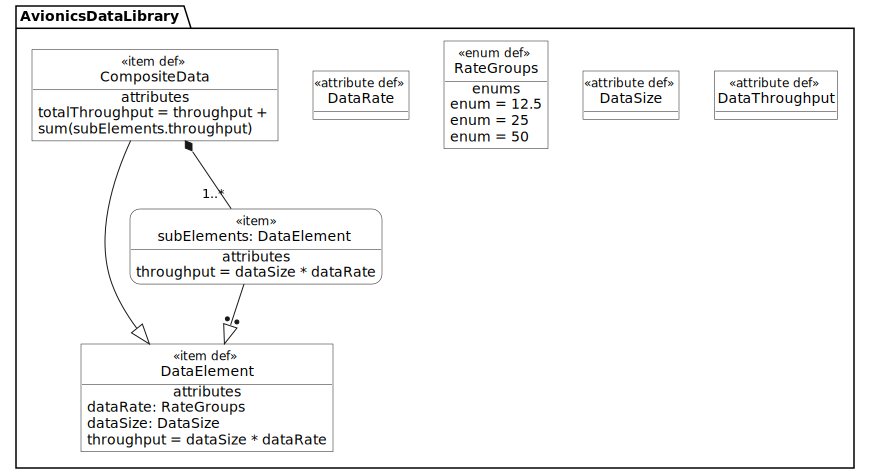

In [94]:
%viz --view=tree AvionicsDataLibrary

In [68]:
package AvionicsHWLibrary {
    
    import AvionicsDataLibrary::*;
    import ScalarValues::Integer;    
    import ScalarValues::Real;
    import NumericalFunctions::*;

    attribute def BusCapacity :> ScalarValues::Integer;
    attribute def Percent :> ScalarValues::Real;
    
    //The port only specifies the interaction point. 
    port def SerialBusPort {
        out item  dataOut : CompositeData;
        in  item  dataIn  : CompositeData;
    }

    //The interface defines the connection between interaction points. 
    interface def SerialBusInterface {
        attribute throughput : DataThroughput;
        attribute maxThroughput : DataThroughput;
        end supplierPort : SerialBusPort;
        end consumerPort : ~SerialBusPort;
        
    }
        
        
    //define the typical HW device
    part def EmbeddedDevice {
        attribute percentCPU_Used : Percent;
        attribute percentVolitileMemoryUsed : Percent;
        attribute percentNonVolitileMemoryUsed : Percent;
        port ports : SerialBusPort[1..*];
    }
    part ComputeDevice : EmbeddedDevice; 

    part SensorDevice : EmbeddedDevice{
        port redefines ports : ~SerialBusPort;
    }
 
}

Package AvionicsHWLibrary (0c49e404-8fe7-4445-81eb-4fd688cd2674)


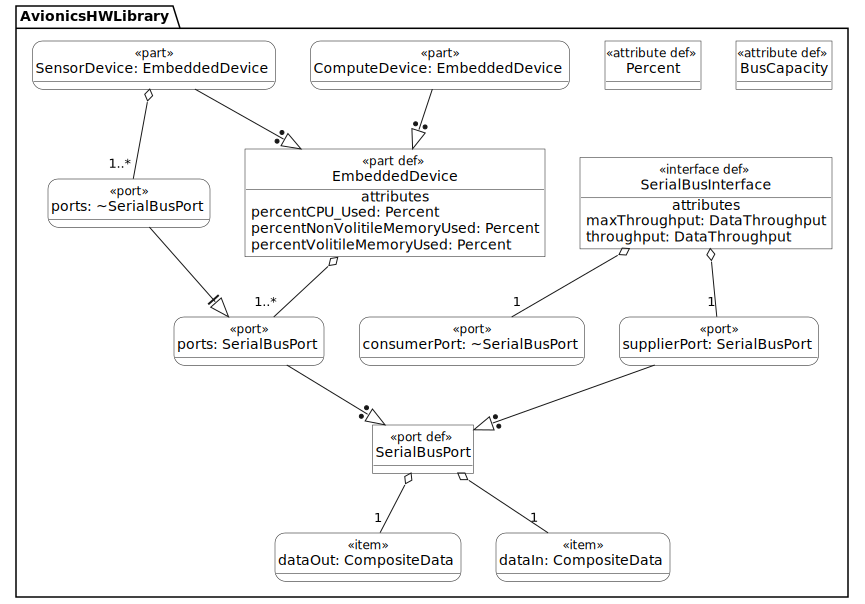

In [69]:
%viz --view=tree AvionicsHWLibrary

In [78]:
package SimpleAvionicsModel {


    import AvionicsDataLibrary::*;
    import AvionicsHWLibrary::*;

       
    part AvionicsSystem {
         
        part busController redefines ComputeDevice {
            //redefine ports
            port bcPort1[1] redefines ports  {
                item sensorData redefines dataIn {
                    subElements[2] redefines subElements;
                    // subsets and :> are the equivalent
                    item pressure[1] subsets subElements;
                    item temp[1] :> subElements;
                }
                // redefines and :>> are equivalent
                item fusedData :>> dataOut {
                    subElements[1] redefines subElements;
                    item altitude[1] :> subElements;
                }
            } 
        }
        
        //congugate the port on the otherside.
        part sensor1 :>> SensorDevice {
            port sensor1Port1[1] :>> ports {
                item sensorData :>> dataOut {
                    subElements[2] :>> subElements;
                    item pressure[1] :> subElements;
                    item temp[1] :> subElements;
                }
            }
        }
        
        
        interface serialBus : SerialBusInterface connect
            supplierPort ::> busController.bcPort1 to 
            consumerPort ::> sensor1.sensor1Port1;
    }
}

Package SimpleAvionicsModel (9da08503-b492-4aeb-8767-690639f6ffc3)


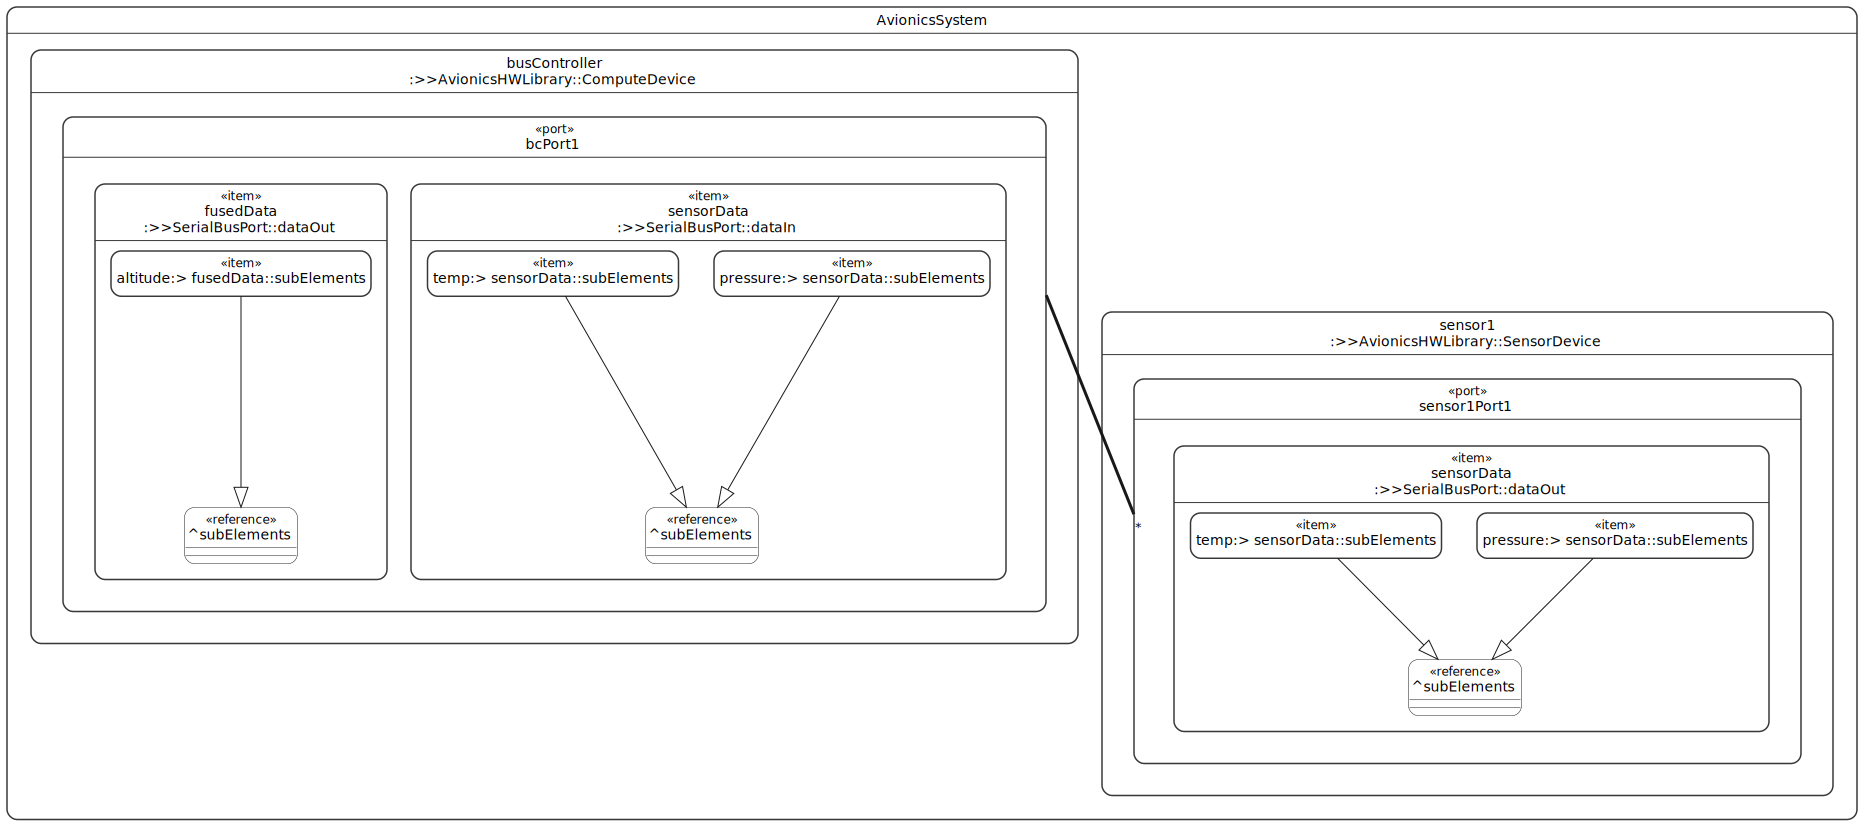

In [79]:
%viz --view=interconnection SimpleAvionicsModel::AvionicsSystem

In [80]:
package NASA_AvionicsModel {


    import SimpleAvionicsModel::*;

    part nasa :> AvionicsSystem {
        
        part bc :>> busController {
            //attribute :>> percentCPU_Used = 50%;
            //attribute :>> percentRAM_Used = 78.2%;
            //attribute :>> percentNonVolitileMemoryUsed = 98.5%;
            port CADCPort:>> sensor1Port {
                item CADCData :>> sensorData{
                    item :>> pressure {
                        attribute :>> dataSize = 8;
                        attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.
                    }
                    item :>> temp {
                        attribute :>> dataSize = 10;
                        attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.                    
                    }
                }
                item :>> fusedData {
                    item :>> altitude {
                        attribute :>> dataSize = 16;
                        attribute :>> dataRate = 50;
                        //throughput should be derived from the attributes above.
                    }
                }
            }
        }
        part CADC :>> sensor1 {
            //attribute :>> percentCPU_Used = 50%;
            //attribute :>> percentRAM_Used = 78.2%;
            //attribute :>> percentNonVolitileMemoryUsed = 98.5%;
            port :>> bcPort {
                item CADCData :>> sensorData{
                    item :>> pressure {
                        attribute :>> dataSize = 8;
                        attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.
                    }
                    item :>> temp {
                        attribute :>> dataSize = 10;
                        attribute :>> dataRate = 25;
                        //throughput should be derived from the attributes above.                    
                    }
                }
            }
        }
        interface A_MUX :>> serialBus connect
            supplierPort ::> bc.CADCPort to 
            consumerPort ::> CADC.bcPort;
                
    }          
}

ERROR:Couldn't resolve reference to Feature 'sensor1Port'. (80.sysml line : 12 column : 30)
ERROR:Couldn't resolve reference to Feature 'sensorData'. (80.sysml line : 13 column : 35)
ERROR:Couldn't resolve reference to Feature 'fusedData'. (80.sysml line : 25 column : 26)
ERROR:Couldn't resolve reference to Feature 'pressure'. (80.sysml line : 14 column : 30)
ERROR:Couldn't resolve reference to Feature 'temp'. (80.sysml line : 19 column : 30)
ERROR:Couldn't resolve reference to Feature 'dataSize'. (80.sysml line : 15 column : 39)
ERROR:Couldn't resolve reference to Feature 'dataRate'. (80.sysml line : 16 column : 39)
ERROR:Couldn't resolve reference to Feature 'dataSize'. (80.sysml line : 20 column : 39)
ERROR:Couldn't resolve reference to Feature 'dataRate'. (80.sysml line : 21 column : 39)
ERROR:Couldn't resolve reference to Feature 'altitude'. (80.sysml line : 26 column : 30)
ERROR:Couldn't resolve reference to Feature 'dataSize'. (80.sysml line : 27 column : 39)
ERROR:Couldn't reso

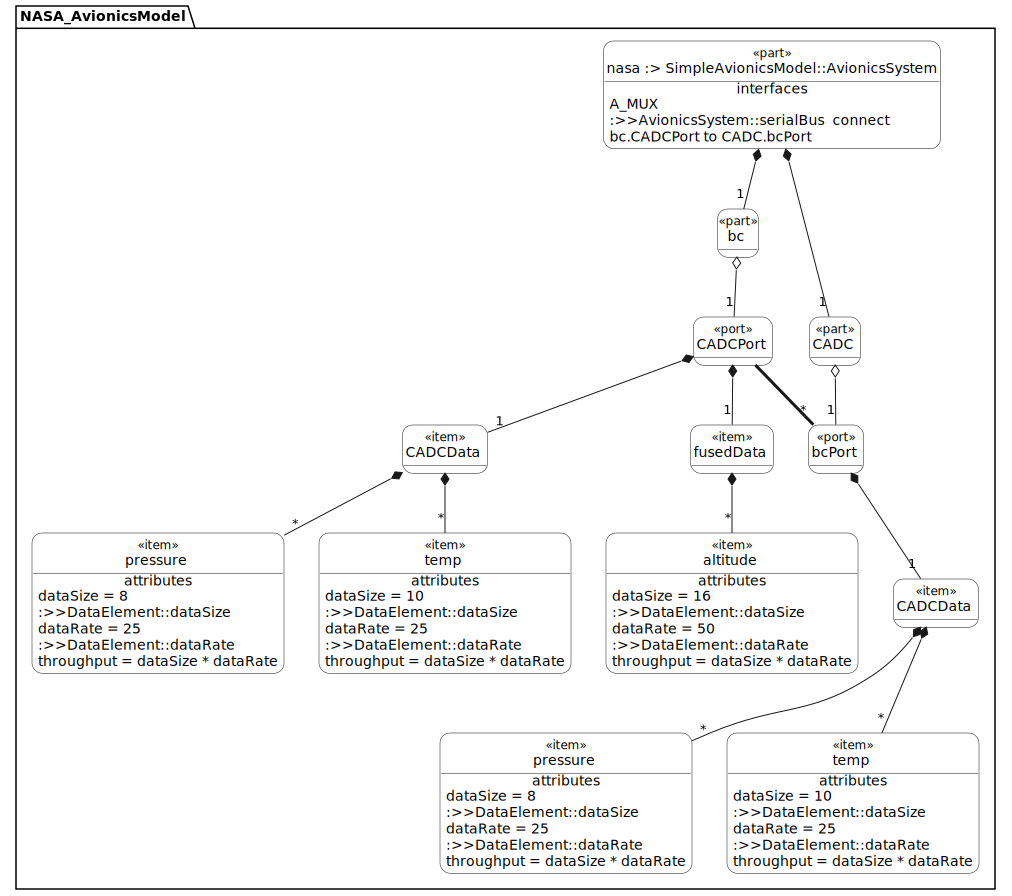

In [81]:
%viz --view=tree NASA_AvionicsModel

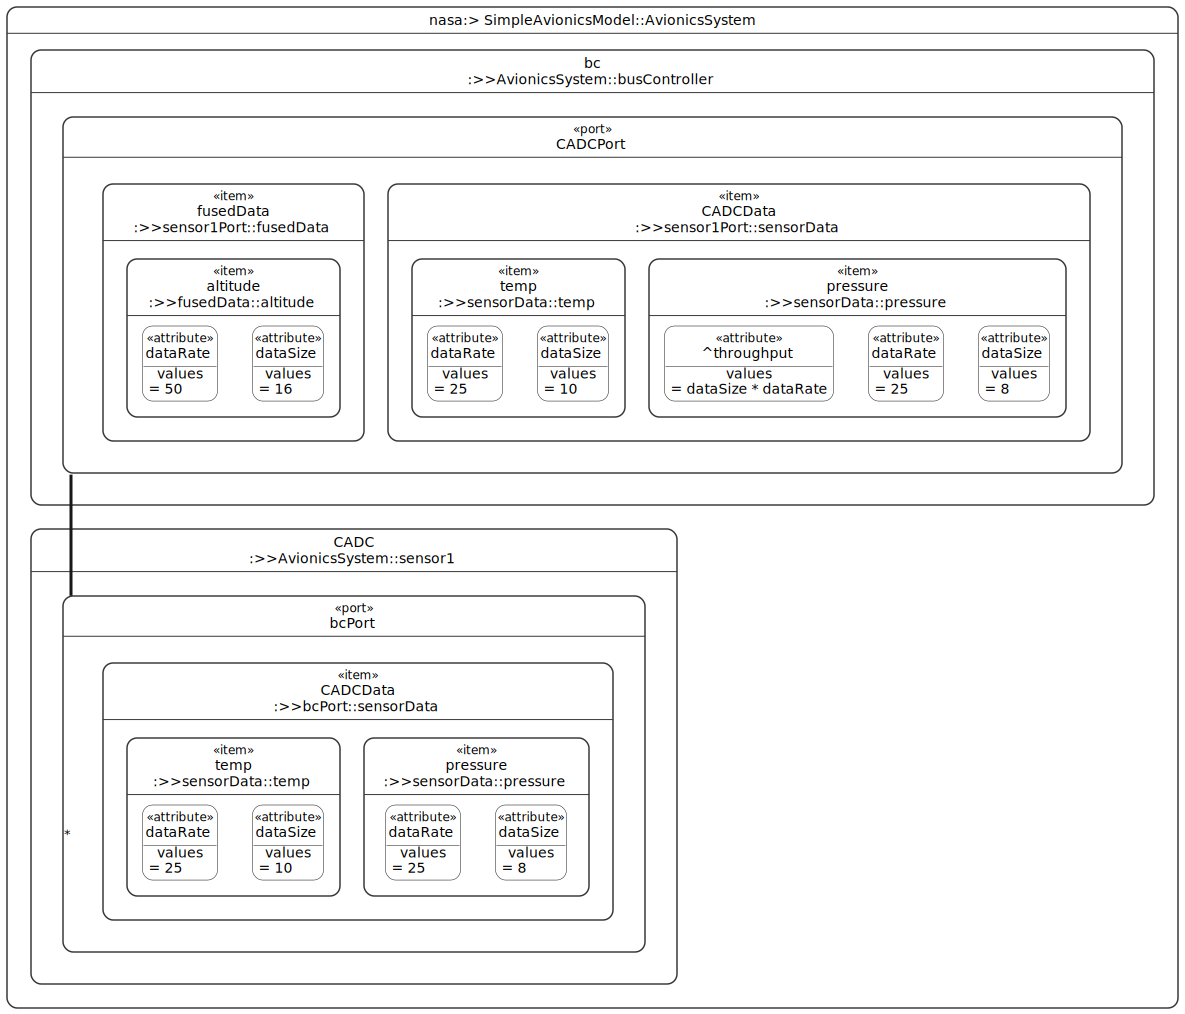

In [44]:
%viz --view=interconnection NASA_AvionicsModel::nasa

## Different ways to visualize the model

Full package view

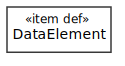

In [45]:
%viz SimpleAvionicsModel::DataElement

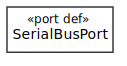

In [46]:
%viz SimpleAvionicsModel::SerialBusPort

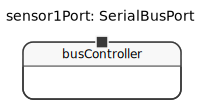

In [49]:
%viz SimpleAvionicsModel::AvionicsSystem::busController